# Processing

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import random
import scipy.stats as stats
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", 100000,"display.max_columns", 100)
# !pip install dingsound
# import dingsound as d
%matplotlib inline

In [ ]:
!git clone 'https://github.com/sangtrankt98/njv_capacity.git'
# ! ls
# ! rm -rf '/content/njv_capacity'

Cloning into 'njv_capacity'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 136 (delta 55), reused 113 (delta 42), pack-reused 0
Receiving objects: 100% (136/136), 43.05 MiB | 19.34 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
lm= pd.read_csv('/content/njv_capacity/capacity calculation/lm_index.csv')
fm= pd.read_csv('/content/njv_capacity/capacity calculation/fm_index.csv')
rts= pd.read_csv('/content/njv_capacity/capacity calculation/rts_index.csv')
kpi= pd.read_csv('/content/njv_capacity/capacity calculation/kpi_index.csv')
driver= pd.read_csv('/content/njv_capacity/capacity calculation/driver_index.csv')
hub= pd.read_csv('/content/njv_capacity/capacity calculation/hub.csv')

In [ ]:
# +0.05*aggregated['succcess_day3_OTP']
aggregated1 = lm.merge(rts,how='left',on= ['cal_date','shipper_group','hub_id'])
aggregated2 = aggregated1.merge(fm,how='outer',on=['cal_date','shipper_group','hub_id'])
aggregated = aggregated2.merge(hub,how='inner',on=['hub_id'])
aggregated.fillna(value = 0,inplace=True)
aggregated['cal_date']=pd.to_datetime(aggregated['cal_date'],format='%Y-%m-%d')
aggregated['created_month']=pd.to_datetime(aggregated['created_month'],format='%Y-%m')
aggregated['area']=aggregated['hub_region'].map({'HN':'Metro','HCM': 'Metro', 'North':'Non-Metro','South': 'Non-Metro'})

In [ ]:
hub_info={
'hub_id':
[1235,191,1233,1239,963],
'hub_name_update':
['HCM - Phu Nhuan - SOU - DP','HCM - District 9 A - SOU - DP','HCM - Go Vap A - SOU - DP','HCM - Tan Binh 1 - SOU - DP','HCM - Can Gio 1 - SOU - DP'],
'hub_id_update':
[236,120,130,823,944]
}
for i in range(len(hub_info)+1):
  aggregated.loc[aggregated['hub_id']==hub_info['hub_id'][i],'hub_name']= hub_info['hub_name_update'][i]
  aggregated.loc[aggregated['hub_id']==hub_info['hub_id'][i],'hub_id']= hub_info['hub_id_update'][i]
  driver.loc[driver['hub_id']==hub_info['hub_id'][i],'hub_id']= hub_info['hub_id_update'][i]

# Calculation & Visulization

In [ ]:
# Mapping driver number
driver_map=driver.merge(hub[['hub_id','hub_region']],how='inner',on='hub_id')
driver_map=driver_map.groupby(['cal_date','hub_region']).agg({'rider_no':'sum','parcel_no':'sum'}).reset_index()
final_result=pd.DataFrame()
sl_rate1=np.around(np.arange(start=0.88, stop=0.98, step=0.01,dtype=np.float64),2).tolist()
sl_rate2=np.around(np.arange(start=0.86, stop=0.96, step=0.01,dtype=np.float64),2).tolist()
col_list=['first_pu_ontime_rate','pu_success_ontime_rate','first_deli_ontime_rate','deli_succcess_ontime_day1_rate','success_rate']
for i,j in zip(sl_rate1,sl_rate2):
  kpi.update(kpi.loc[kpi['hub_region'].isin(['HN','HCM'])].replace(to_replace={col:sl_rate1 for col in col_list},value=i),overwrite=True)
  kpi.update(kpi.loc[kpi['hub_region'].isin(['North','South'])].replace(to_replace={col:sl_rate2 for col in col_list},value=j),overwrite=True)
  calculation = aggregated.merge(kpi,how='left',on=['shipper_group','hub_region'],suffixes=('','_kpi'))
  calculation['total_volume']= calculation.apply(lambda row: row.fm_orders + row.lm_orders, axis=1)
  # Calculation the percentage of each shipper group
  percentage=calculation.groupby(['cal_date','hub_id','shipper_group']).agg({'total_volume':'sum'}).groupby(['cal_date','hub_id']).apply(lambda x: x/x.sum()).reset_index()
  percentage.sort_values(by=['cal_date','hub_id'],inplace= True)
  percentage.fillna(value = 0,inplace=True)
  percentage.columns=['cal_date', 'hub_id', 'shipper_group', 'total_volume_percentage']
  ## percentage[percentage['total_volume'].isnull()]
  calculation=calculation.merge(percentage,how='left',on=['cal_date','shipper_group','hub_id'])
  # Calculate service level score
  calculation.fillna(value = 0,inplace=True)
  calculation['check6']=calculation['first_deli_ontime_rate'].ne(0).astype(int)
  calculation['check7']=calculation['deli_succcess_ontime_day1_rate'].ne(0).astype(int)
  calculation['check8']=calculation['first_pu_ontime_rate'].ne(0).astype(int)
  calculation['check9']=calculation['pu_success_ontime_rate'].ne(0).astype(int)
  calculation['check10']=calculation['success_rate'].ne(0).astype(int)
  calculation['actual_score']=calculation.apply(lambda x: (x.first_deli_ontime_rate*x.check1 + x.deli_succcess_ontime_day1_rate*x.check2 + x.first_pu_ontime_rate*x.check3 + x.pu_success_ontime_rate*x.check4 + x.success_rate*x.check5)*x.total_volume_percentage , axis=1)
  calculation['kpi_score']=calculation.apply(lambda x: (x.first_deli_ontime_rate_kpi*x.check6 + x.deli_succcess_ontime_day1_rate_kpi*x.check7 + x.first_pu_ontime_rate_kpi*x.check8 + x.pu_success_ontime_rate_kpi*x.check9 + x.success_rate_kpi*x.check10)*x.total_volume_percentage , axis=1)

  # prepare conditions
  pre_final=calculation[['cal_date','shipper_group','hub_region','hub_name','hub_id','fm_orders','lm_orders','total_volume','actual_score','kpi_score']]
  pre_final = pre_final[pre_final['total_volume'].isnull()==False]
  # Filter 1: active day
  filter1 = pre_final.groupby(['hub_name','hub_id']).agg({'cal_date':pd.Series.nunique}).reset_index()
  hub_low_time=filter1[filter1['cal_date']<=60]['hub_name'].to_list()
  pre_final=pre_final[(~pre_final['hub_name'].isin(hub_low_time))&(pre_final['cal_date']<=dt.datetime(2021,4,30))]
  # Filter 2: volume/day
  filter2 = pre_final.groupby(['hub_name','hub_id']).agg({'total_volume':'mean'}).reset_index()
  hub_low_workload=filter2[filter2['total_volume']<=5]['hub_name'].to_list()
  pre_final=pre_final[~pre_final['hub_name'].isin(hub_low_workload)]
  # Filter 3: remove low score
  final=pre_final.groupby(['cal_date','hub_region']).agg({'total_volume':'sum','actual_score':'sum','kpi_score':'sum'}).reset_index()
  final=final[final['actual_score']>=final['kpi_score']]
  # Remove outlier & calulate z-score
  final['z_score_total_volume']=final.groupby(['hub_region']).total_volume.transform(lambda x : stats.zscore(x,ddof=1))
  final['mean_total_volume']=final.groupby(['hub_region']).total_volume.transform(lambda x : x.mean())
  final['std_total_volume']=final.groupby(['hub_region']).total_volume.transform(lambda x : x.std(ddof=1))
  final['q1_z']=final.groupby(['hub_region']).z_score_total_volume.transform(lambda x : x.quantile(.25))
  final['q3_z']=final.groupby(['hub_region']).z_score_total_volume.transform(lambda x : x.quantile(.75))
  final['lower_z']=final.apply(lambda x: 2.5*x.q1_z-1.5*x.q3_z, axis=1)
  final['upper_z']=final.apply(lambda x: 2.5*x.q3_z-1.5*x.q1_z, axis=1)
  ## Filter
  final = final[(final['z_score_total_volume']>=final['lower_z'])&(final['z_score_total_volume']<=final['upper_z'])]
  observation = final[['hub_region','cal_date']].groupby(['hub_region']).agg('count').reset_index()
  observation.rename(columns={'cal_date': 'observation_num'},inplace=True)
  # Calculate confidence interval
  hub_region=list(final['hub_region'].unique())
  result= pd.DataFrame()
  for hub_region in hub_region:
    data=stats.bayes_mvs(final[final['hub_region']==hub_region]['total_volume'],alpha= 0.9)
    dict =  {
    'hub_region':hub_region,
    'mean': [data[0][0]],
    'lower': [data[0][1][0]],
    'upper': [data[0][1][1]],
    'range': data[0][1][1]-data[0][1][0],
    'sl_rate1': i,
    'sl_rate2': j
    }
    append = pd.DataFrame.from_dict(dict)
    result= result.append(append)
  result=result.merge(driver_map,how='left',on='hub_region')
  result=result.merge(observation,how='left',on='hub_region')
  pre_result = result[(result['parcel_no']<=result['upper'])&(result['parcel_no']>=result['lower'])].groupby(['hub_region','sl_rate1','sl_rate2','observation_num']).agg({'mean':'mean','lower':'mean','upper':'mean','range':'mean','rider_no':'mean'}).reset_index()
  final_result = final_result.append(pre_result)
final_result=final_result.round({'rider_no':0,'mean':-2,'upper':-2,'lower':-2}).reset_index(drop=True)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


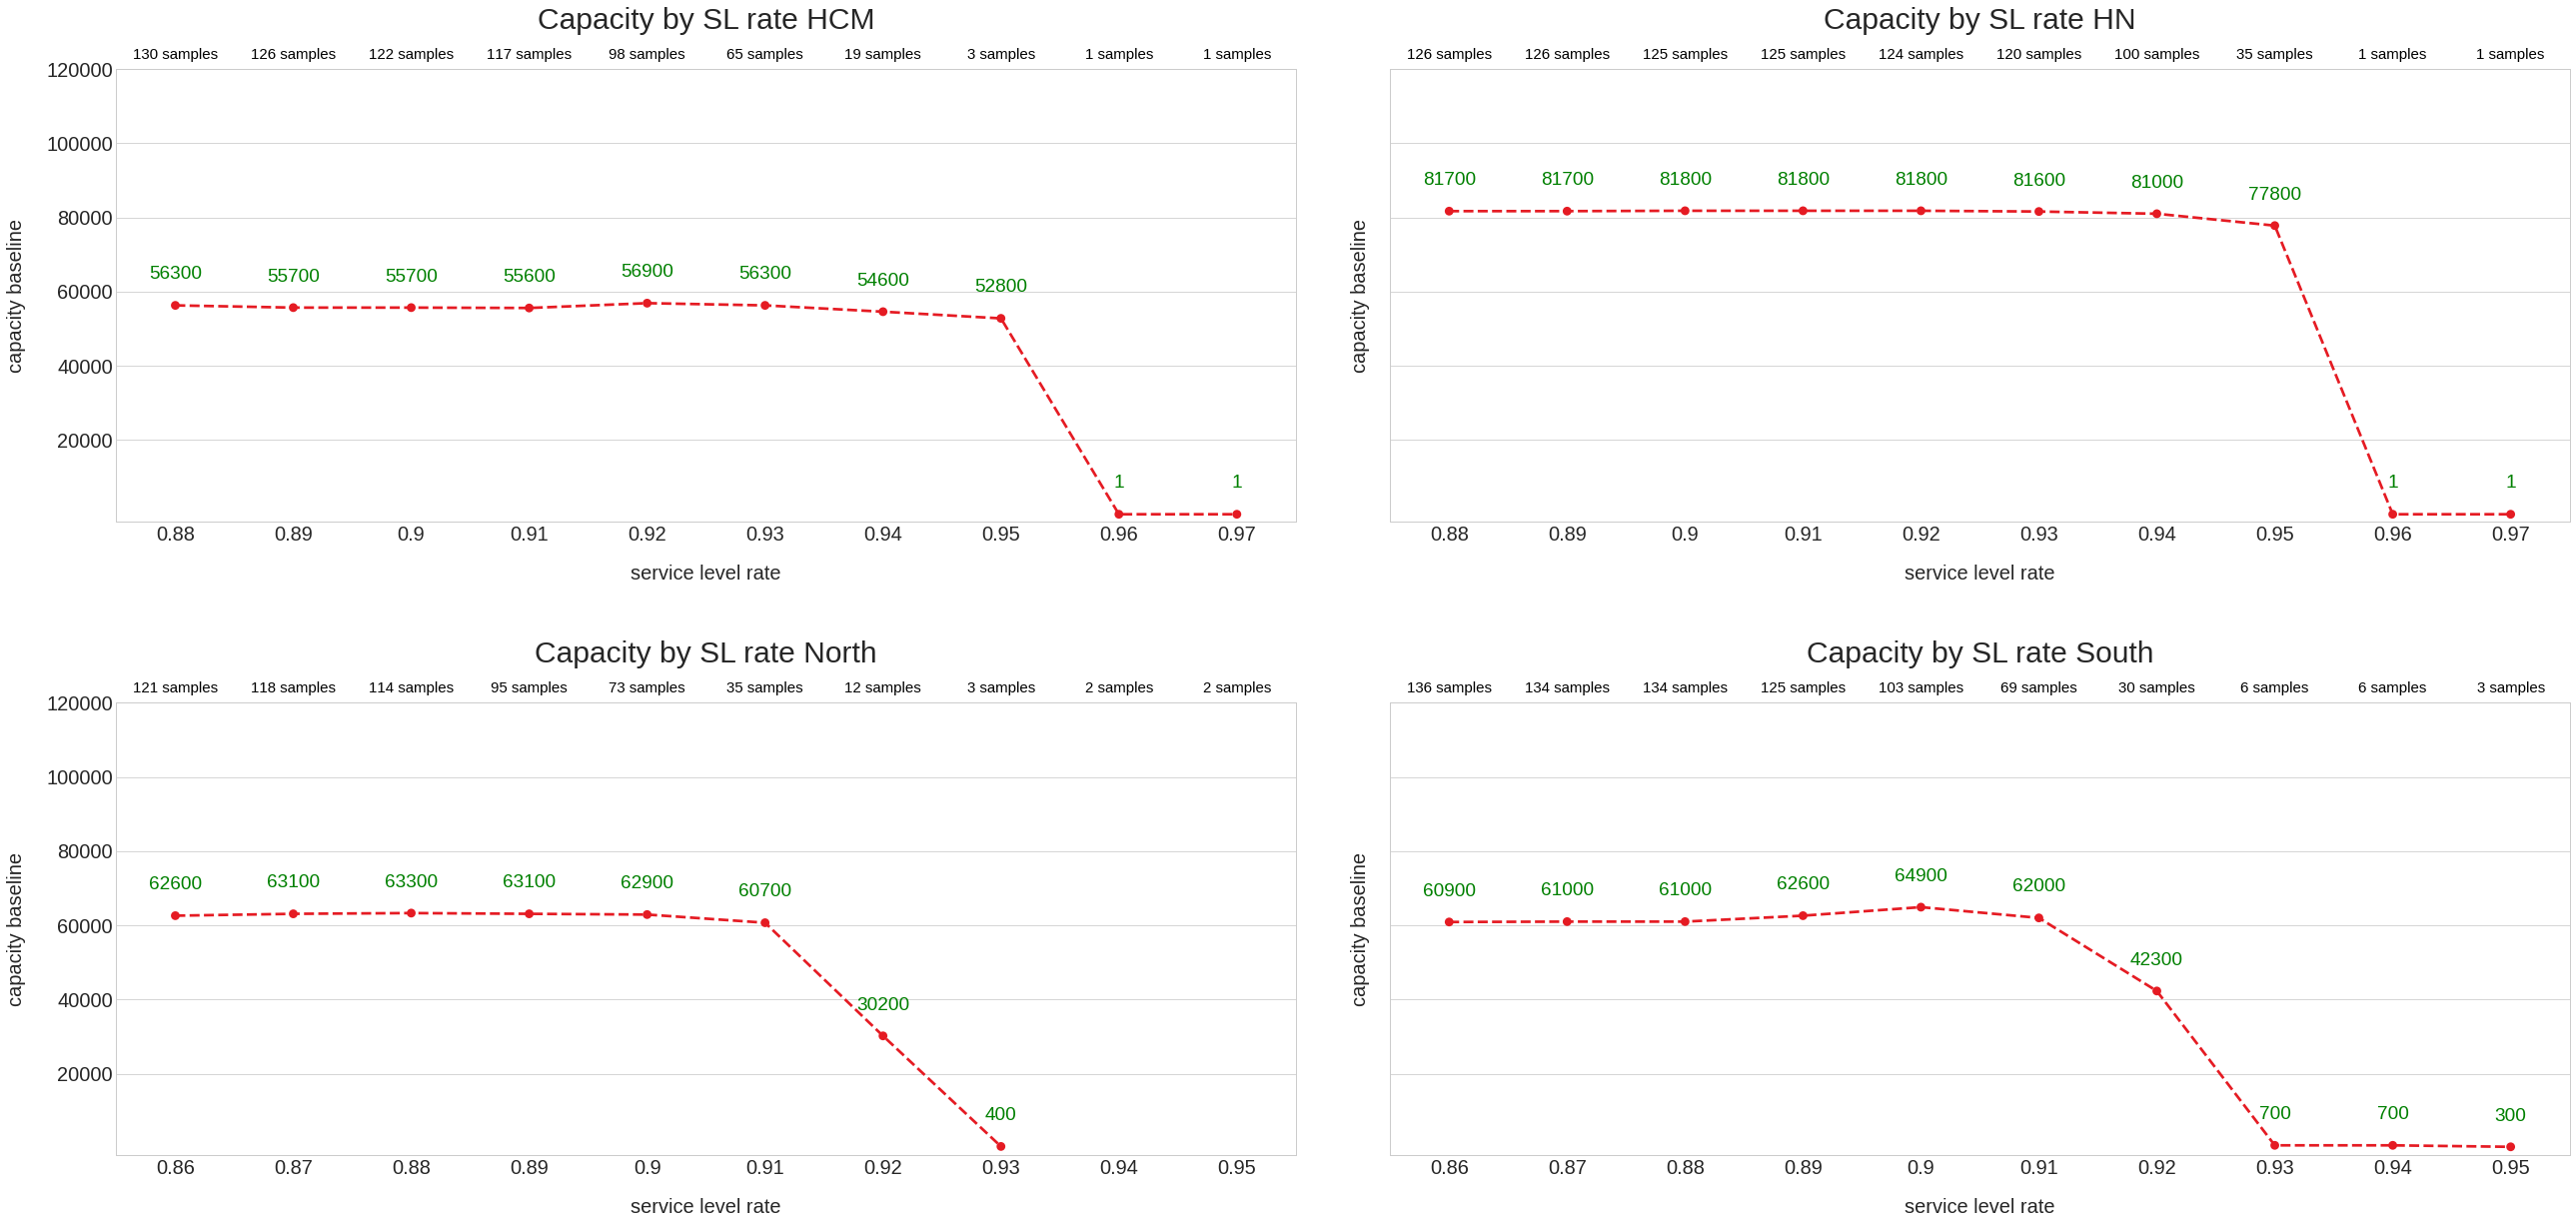

In [3]:
plt.style.use('seaborn-whitegrid')
params = {'legend.fontsize': 30,
          'axes.labelsize': 20,
          'axes.titlesize':30,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'axes.titlepad':6.0,
          'axes.labelpad':20.0,
          'figure.subplot.wspace': 0.08,
          'figure.subplot.hspace': 0.4,
          }
# pylab.rcParams.keys()
pylab.rcParams.update(params)
fig1, ax1 = plt.subplots(2, 2, figsize=(44, 20),squeeze=False, sharey=True)
# fig1.update(wspace=0.05)
ax1 = ax1.ravel()
for i,j in enumerate(final_result.hub_region.unique().tolist()):
  if j in {'HCM','HN'}:
    sns.pointplot(x='sl_rate1',y='mean'
                  ,data= final_result[final_result['hub_region']==j]
                  ,ci='range'
                  ,markers='o',errwidth=3,linestyles='--',color='#E51B23',capthick=2,ax=ax1[i])
  else :
    sns.pointplot(x='sl_rate2',y='mean'
                  ,data= final_result[final_result['hub_region']==j]
                  ,ci='range'
                  ,markers='o',errwidth=3,linestyles='--',color='#E51B23',capthick=2,ax=ax1[i])
  ax1[i].set_title('Capacity by SL rate ' + str(j),loc='center',pad =40.0)
  ax1[i].set_xlabel('service level rate',labelpad =20.0)
  ax1[i].set_ylabel('capacity baseline',labelpad =20.0)
  ax1[i].set_yticks(ticks=np.arange(20000,140000,20000))
  ax1[i].set_ylim(ymin=-2000, ymax=120000)
  # sns.despine() remove spines
  for p in zip(ax1[i].get_xticks(), final_result[final_result['hub_region']==j]['mean']):
    ax1[i].text(p[0],p[1]+6000,format(p[1],'.0f'),color='g',fontsize=19,ha = 'center', va = 'bottom')
  for p in zip(ax1[i].get_xticks(),final_result[final_result['hub_region']==j]['observation_num']):
    ax1[i].text(p[0],ax1[i].get_ylim()[1]+2000,format(p[1],'.0f')+' samples',color='black',fontsize=15,ha = 'center', va = 'bottom')

In [ ]:
ax1[1].get_ylim()[1]

# Data Final

In [ ]:
final_result.to_csv('/content/drive/MyDrive/Capacity Project/Data Result/find_sl_rate.csv')